# Запуск симуляции

In [1]:
import gc
import os
import datetime
import numpy as np
from tqdm.notebook import tqdm
import math

from utils import merge_sim
from sim import FunctionType, Simulation, StaticSimulation, SimulationResults, LinearSimulation, LinearSimulationStatic, LongstepSimulation, LongstepSimulationStatic, SimulationEnsemble
from graph import GraphType, CompleteGraph, RingGraph, RingGraphWithSubgraph, RocGraph, ErGraph, CompleteGraph, TwoCityGraph
from rw_utils import pickle_obj
from db import SimulationDatabase, SimulationDirectory
import uuid
import scipy.stats as stats
import pandas as pd

In [30]:
num_nodes = 200
nums_edges = [ 300, 600, 800, 850] 
graph_types = [ 
	GraphType.ring_subgraph,
	GraphType.two_city, 
] 
fractions = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
num_runs_times = 2 # Количество генераций для определенного типа графов
num_runs = 2 # Количество симуляций над определенной генерацией определенного типа графа

# Параметры симуляции для каждого типа графа (в данном случае два)
params = [
	[
		{
			GraphType.ring_subgraph: {
				'graph': None,
				'eps': 0,
				'beta_0': 0.9999,
				'beta_1': 1,
				'alpha_0': 0.0001,
				'alpha_1': 0.0,
				'X': np.array([[0.035, .8], [0.035, .8]]), # RINGS
				'max_num_iter': 150_000,
				'end_condition': 1,
			},
			GraphType.two_city: {
				'graph': None,
				'eps': 0,
				'beta_0': 0.9999,
				'beta_1': 1,
				'alpha_0': 0.0001,
				'alpha_1': 0.0,
				'X': np.array([[0.035, .8], [0.035, .8]]), # CITIES
				'max_num_iter': 150_000,
				'end_condition': 1,
			}
		}
		for _ in range(len(nums_edges))
	]
]

# Создаем через цикл уникальные записи в словарь. 
# Для каждого графа создаем запись с новым долевым распределением
graphs = []
for _ in params:
	graph = {}
	for edges in nums_edges:
		for graph_type in graph_types:
			for shift, fraction in enumerate(fractions): 
				if (graph_type == GraphType.two_city and fraction > 0.5):
					continue
				
				if (graph_type == GraphType.ring_subgraph):
					graph[(graph_type, edges + shift)] = (RingGraphWithSubgraph, {
						'num_nodes': num_nodes, 
						'additional_edges': edges - num_nodes, 
						'subgraph_edge_fraction': fraction,
						'random_nodes_position': True,
						'num_nodes_subgraph': None,
					})
				if (graph_type == GraphType.two_city):
					graph[(graph_type, edges + shift)] = (TwoCityGraph, {
						'num_nodes': num_nodes,
						'additional_edges': edges - num_nodes,
						'subgraph_edge_fraction': fraction,
						'num_shared_edges': 1,
						'num_nodes_subgraph': None,
					})
	graphs.append(graph)
	
# Здесь установлен только один тип симуляций%: 
# без статических вершин и с кусочно-линейной функцией

# (FunctionType, static): Simulation
simulations = {
    (FunctionType.longstep, False): LongstepSimulation,
}

## Run

Careful with parameters for `Longstep, RocGraph(4x25)` and `Longstep, RingGraph(100,24)`.

In [31]:
sim_id = uuid.uuid4()
for num_run in range(num_runs_times):
	print(f"\nRUN: {num_run + 1}\n")
	for ex in range(len(params)):
		print(f"\nEXPERIMENT: {ex + 1}\n")
		for (graph_type, num_edges), (graph_class, graph_params) in graphs[ex].items():
			# Если количество ребер используется для определения зависимости времени от количества ребер
			ie = None
			for i in range(len(nums_edges)):
				if (num_edges - 40 <= nums_edges[i] <= num_edges + 40):
					ie = i
					break
			if (ie == None):
				raise RuntimeError("There is no such edges")
			
			simulations_ids = f"run{num_run}_____{sim_id}\\exp{ex}\\e{nums_edges[ie]}\\{graph_type}"
			
			for (func_type, static), simulation_class in simulations.items():
				params[ex][ie][graph_type]['graph'] = graph_class(**graph_params)
				
				sim = simulation_class(**params[ex][ie][graph_type])
				sim_ensemble = SimulationEnsemble(sim, num_runs, simulations_ids)
				sim_ensemble.run()


RUN: 1


EXPERIMENT: 1



LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 57.33it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 30.06it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 68.46it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 68.70it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 51.29it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 75.13it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 42.21it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.45,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 28.55it


RUN: 2


EXPERIMENT: 1



LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 28.24it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 40.24it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 22.77it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 74.27it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 43.22it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 69.41it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 54.41it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.45,pos=random) (300 edges): 100%|██████████| 2/2 [00:00<00:00, 38.93it

# Статистика

В данном случае указывается путь до определенной симуляции. В результате будет получено максимальное и среднее время эволюции для выбранной генерации графов, а также для определенного эксперимента. Все результаты будут записаны в excel таблицу и сохранены в папке проекта.

Путь к симуляции задается в переменную `simulation_id`, который состоит из 4 частей:
- номер генерации с идентификатором (Прим.: `run0_____20b568b4-11de-4a98-8722-f0b61d57b818`)
- номер эксперимента (Прим.: `exp0`) - он используется, если нужно сделать несколько симуляций с разными параметрами одновременно. Для каждого такого "эксперимента" будет создана собственная папка

В результате путь в переменной должен выглядеть следующим образом:
```python
simulation_source = 'run0_____20b568b4-11de-4a98-8722-f0b61d57b818\\exp0'
```

**ВАЖНО:** в переменной путь должен разделяться двумя знаками `\` (В UNIX системах это `/`)

In [33]:
simulation_source = 'run0_____1db09418-c08d-4d3c-858c-24ca12c851e7\\exp0'

# --- --- ---
 
def segment_intersection(a1, a2, b1, b2):
    if a2 < b1:
        return '<'
    elif b2 < a1:
        return '>'
    else:
        return '='


dataframe = pd.DataFrame(columns=['num_edges', 'graph_type', '95% left', '95% right', 't_mean', 't_sem', 't_max', 'comparison'])
for edge in nums_edges:
	for GRAPH_TYPE in graph_types: 
		simulation_id = f'{simulation_source}\\e{edge}\\{GRAPH_TYPE}'
		sdb = SimulationDatabase(path=f'output\\{simulation_id}\\')
		cycle = {'graph': '', 'value':0}
		for (graph_type, num_edges), (_, graph_params) in graphs[0].items():

			if (cycle['graph'] == graph_type and cycle['value'] == 1):
				continue
			else: 
				cycle['graph'] = graph_type
				cycle['value'] = 0
			for (func_type, static), _ in simulations.items():
				
				sdirs = [
					sdir
					for sdir in sdb.sdirs
					if (num_edges - 30 <= sdir.sim.graph.graph.number_of_edges() <= num_edges + 30) and
					(sdir.sim.graph.graph_type == graph_type)
				]
				num_sims = len(fractions) if graph_type == GraphType.ring_subgraph else len([f for f in fractions if f <= 0.5])
				for sdir in sdirs:
					sdir.cache()
					sdir.info()
					t_sem = stats.sem(sdir.times)
					interval = stats.norm.interval(confidence=0.95, loc=sdir.t_mean_1, scale=t_sem)
					
					do_count_intersection = dataframe[dataframe.columns[0]].count()
					
					if (do_count_intersection > 0): 
						last_data = dataframe.iloc[-1]
					new_data = [num_edges, 
									graph_type, 
									interval[0],  
									interval[1], 
									sdir.t_mean_1,
									t_sem, 
									sdir.t_max, 
									segment_intersection(
										interval[0], 
										interval[1],
										last_data['95% left'], 
										last_data['95% right']) 
										if do_count_intersection > 0 else '']
					dataframe.loc[len(dataframe)] = new_data
					
					del sdir
				cycle['value'] = 1
				gc.collect()
dataframe.to_excel("output_edges_dependency.xlsx")


d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 100.0
tmax = 145
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 268.5
tmax = 307
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 100.5
tmax = 116
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 107.5
tmax = 164
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 145.0
tmax = 212
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 86.0
tmax = 113
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=random), 300 edg

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.1), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 141.0
tmax = 144
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.15), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 132.0
tmax = 136
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.2), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 192.0
tmax = 263
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.25), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 171.5
tmax = 257
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.3), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 274.5
tmax = 370
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.35), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 191.0
tmax = 229
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.4), 300 edges (2 runs)
E[t|~A] = nan
E[t|A] = 131.5
tmax = 

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 460.0
tmax = 755
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 514.0
tmax = 853
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 293.0
tmax = 439
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 450.5
tmax = 521
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 585.0
tmax = 917
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 1084.5
tmax = 1733
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=random), 600 

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=400,sh_e=1,p=0.1), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 416.5
tmax = 611
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=400,sh_e=1,p=0.15), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 472.0
tmax = 716
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=400,sh_e=1,p=0.2), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 327.0
tmax = 385
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=400,sh_e=1,p=0.25), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 382.5
tmax = 565
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=400,sh_e=1,p=0.3), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 554.0
tmax = 699
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=400,sh_e=1,p=0.35), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 225.0
tmax = 337
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=400,sh_e=1,p=0.4), 600 edges (2 runs)
E[t|~A] = nan
E[t|A] = 184.0
tmax = 

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 3468.5
tmax = 6271
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 1556.0
tmax = 2346
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 1672.5
tmax = 2157
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 1331.5
tmax = 1883
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 929.5
tmax = 1545
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 3098.0
tmax = 5090
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=rand

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=600,sh_e=1,p=0.1), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 11551.0
tmax = 18923
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=600,sh_e=1,p=0.15), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 2877.0
tmax = 4067
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=600,sh_e=1,p=0.2), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 4843.0
tmax = 7634
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=600,sh_e=1,p=0.25), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 1116.5
tmax = 1156
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=600,sh_e=1,p=0.3), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 1381.0
tmax = 1886
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=600,sh_e=1,p=0.35), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] = 2309.5
tmax = 2737
SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=600,sh_e=1,p=0.4), 800 edges (2 runs)
E[t|~A] = nan
E[t|A] =

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 850 edges (2 runs)
E[t|~A] = nan
E[t|A] = 6646.0
tmax = 11031
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random), 850 edges (2 runs)
E[t|~A] = nan
E[t|A] = 1565.5
tmax = 2001
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random), 850 edges (2 runs)
E[t|~A] = nan
E[t|A] = 2770.5
tmax = 4788
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random), 850 edges (2 runs)
E[t|~A] = nan
E[t|A] = 3940.5
tmax = 5412
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random), 850 edges (2 runs)
E[t|~A] = nan
E[t|A] = 3313.0
tmax = 6084
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random), 850 edges (2 runs)
E[t|~A] = nan
E[t|A] = 11233.0
tmax = 16059
SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.time

# Отрисовка графиков

In [34]:
import os
import gc
import numpy as np
from matplotlib import pyplot as plt

from sim import FunctionType, StaticSimulation, FunctionType
from graph import GraphType, RingGraph, RocGraph, ErGraph
from plot import SigmaPlot
from db import SimulationDatabase, SimulationDirectory
from utils import sigma_mean, sigmas, pad
from rw_utils import read_pickled, deserialize_boolean_array
from animate import animate

%matplotlib inline

In [35]:
color = {
    GraphType.ring_subgraph: [
      	'#ff0000', #ff6666
		'#ff5901',
		'#ffb202', #ffd167
		'#f4ff03',
		'#9dff04', #c4ff68
		'#47ff05',
		'#06ff1c',
		'#07ff73',
		'#09ffc9', #6bffdf
		'#0adfff',
		'#0b8bff',
		'#0c37ff',
		'#360dff',
		'#8b0eff',
		'#df0fff',

	],
    GraphType.two_city: [
      	'#ff0000',
		'#ff5901',
		'#ffb202',
		'#f4ff03',
		'#9dff04',
		'#47ff05',
		'#06ff1c',
		'#07ff73',
		'#09ffc9',
		'#0adfff',
		'#0b8bff',
		'#0c37ff',
		'#360dff',
		'#8b0eff',
		'#df0fff',
	],
}

x_right = {
    FunctionType.linear: 2000,
    FunctionType.longstep: 8000 
}

label = {
    GraphType.ring_subgraph: 'Кольцо с подграфом',
    GraphType.two_city: 'Два города',
}

## Для начала объединим все симуляции со всеми генерациями

In [36]:
from utils import merge_sim
from graph import GraphType

merge_exp = [0] # Номера экспериментов
merge_edges = nums_edges.copy()
merge_graph_type = [GraphType.ring_subgraph, GraphType.two_city]

for exp in merge_exp:
  for edge in merge_edges:
    for graph_type in merge_graph_type:
      search_sim = f"exp{exp}\\e{edge}\\{graph_type}"
      print(f"SEARCHING FOR: {search_sim}")
      merge_sim(["output"], search_sim, "output\\merged")


SEARCHING FOR: exp0\e300\ring_subgraph
output\merged\merge\exp0\e300
SEARCHING FOR: exp0\e300\two_city
SEARCHING FOR: exp0\e600\ring_subgraph
output\merged\merge\exp0\e600
SEARCHING FOR: exp0\e600\two_city
SEARCHING FOR: exp0\e800\ring_subgraph
output\merged\merge\exp0\e800
SEARCHING FOR: exp0\e800\two_city
SEARCHING FOR: exp0\e850\ring_subgraph
output\merged\merge\exp0\e850
SEARCHING FOR: exp0\e850\two_city


## Теперь отрисуем

Здесь достаточно в `simulation_id` вписать номер эксперимента. **ВАЖНО:** здесь также нужно указать количество ребер, для которых будут рисоваться графики
Также можно указать границы, на которые будут отрисовываться графики в переменной `borders`

### Единичные симуляции
Если нужно отобразить их: надо изменить `show_exact_simulation` с `False` на `True`.

Также, нужно выбрать номер доли (fraction), для которой будут отображаться единичные симуляции. Они задаются в словаре `exact_simulations`.

Все единичные симуляции отображаются прозрачным черным цветом.

caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (4 runs)...
caching SimulationDirectory for 

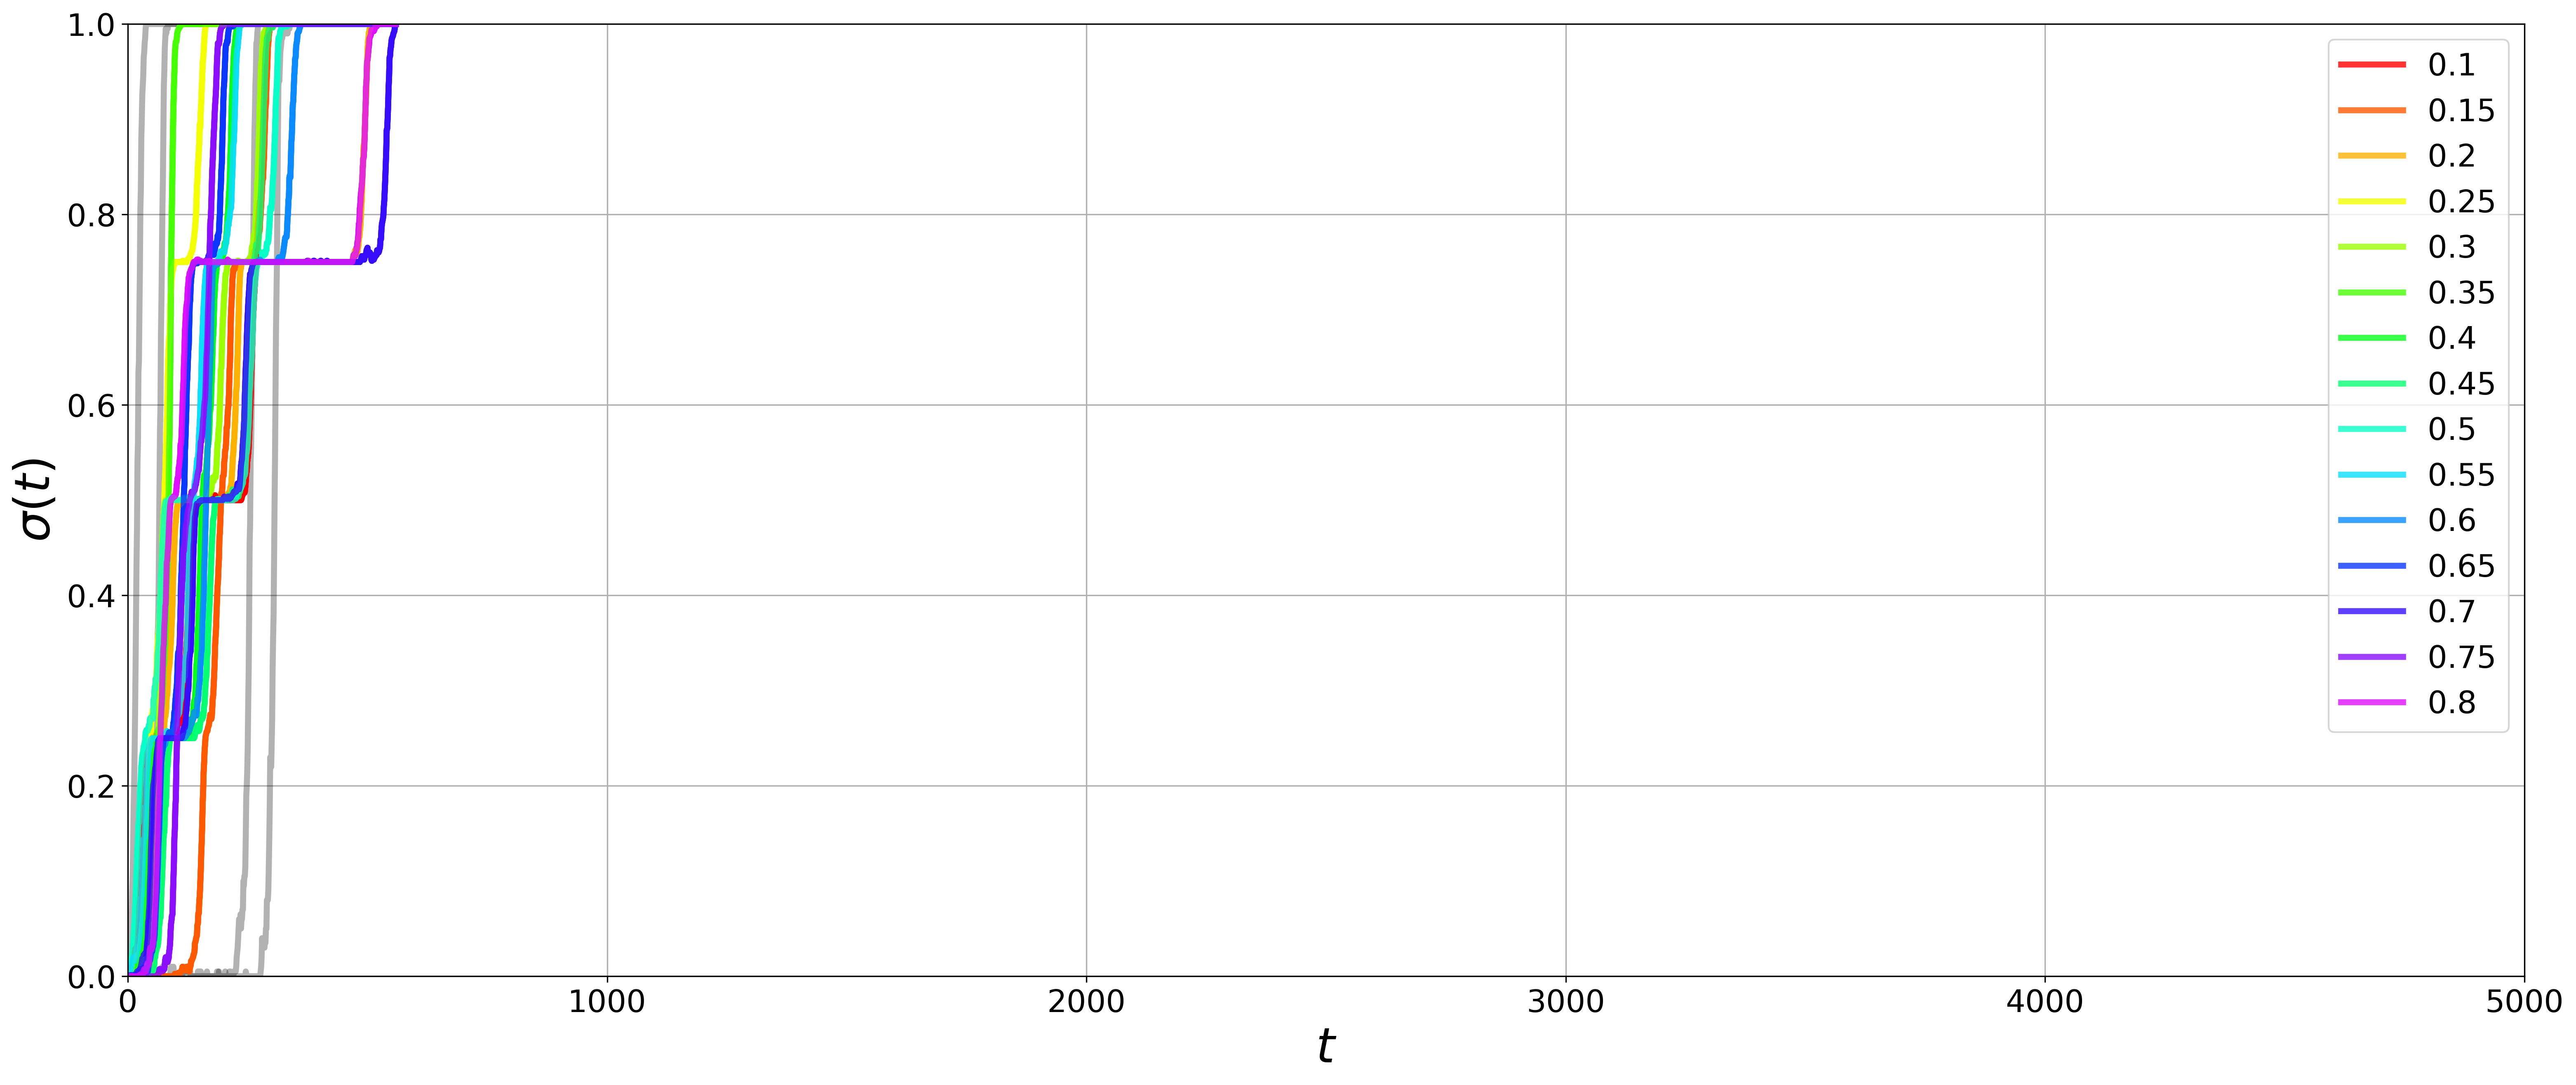

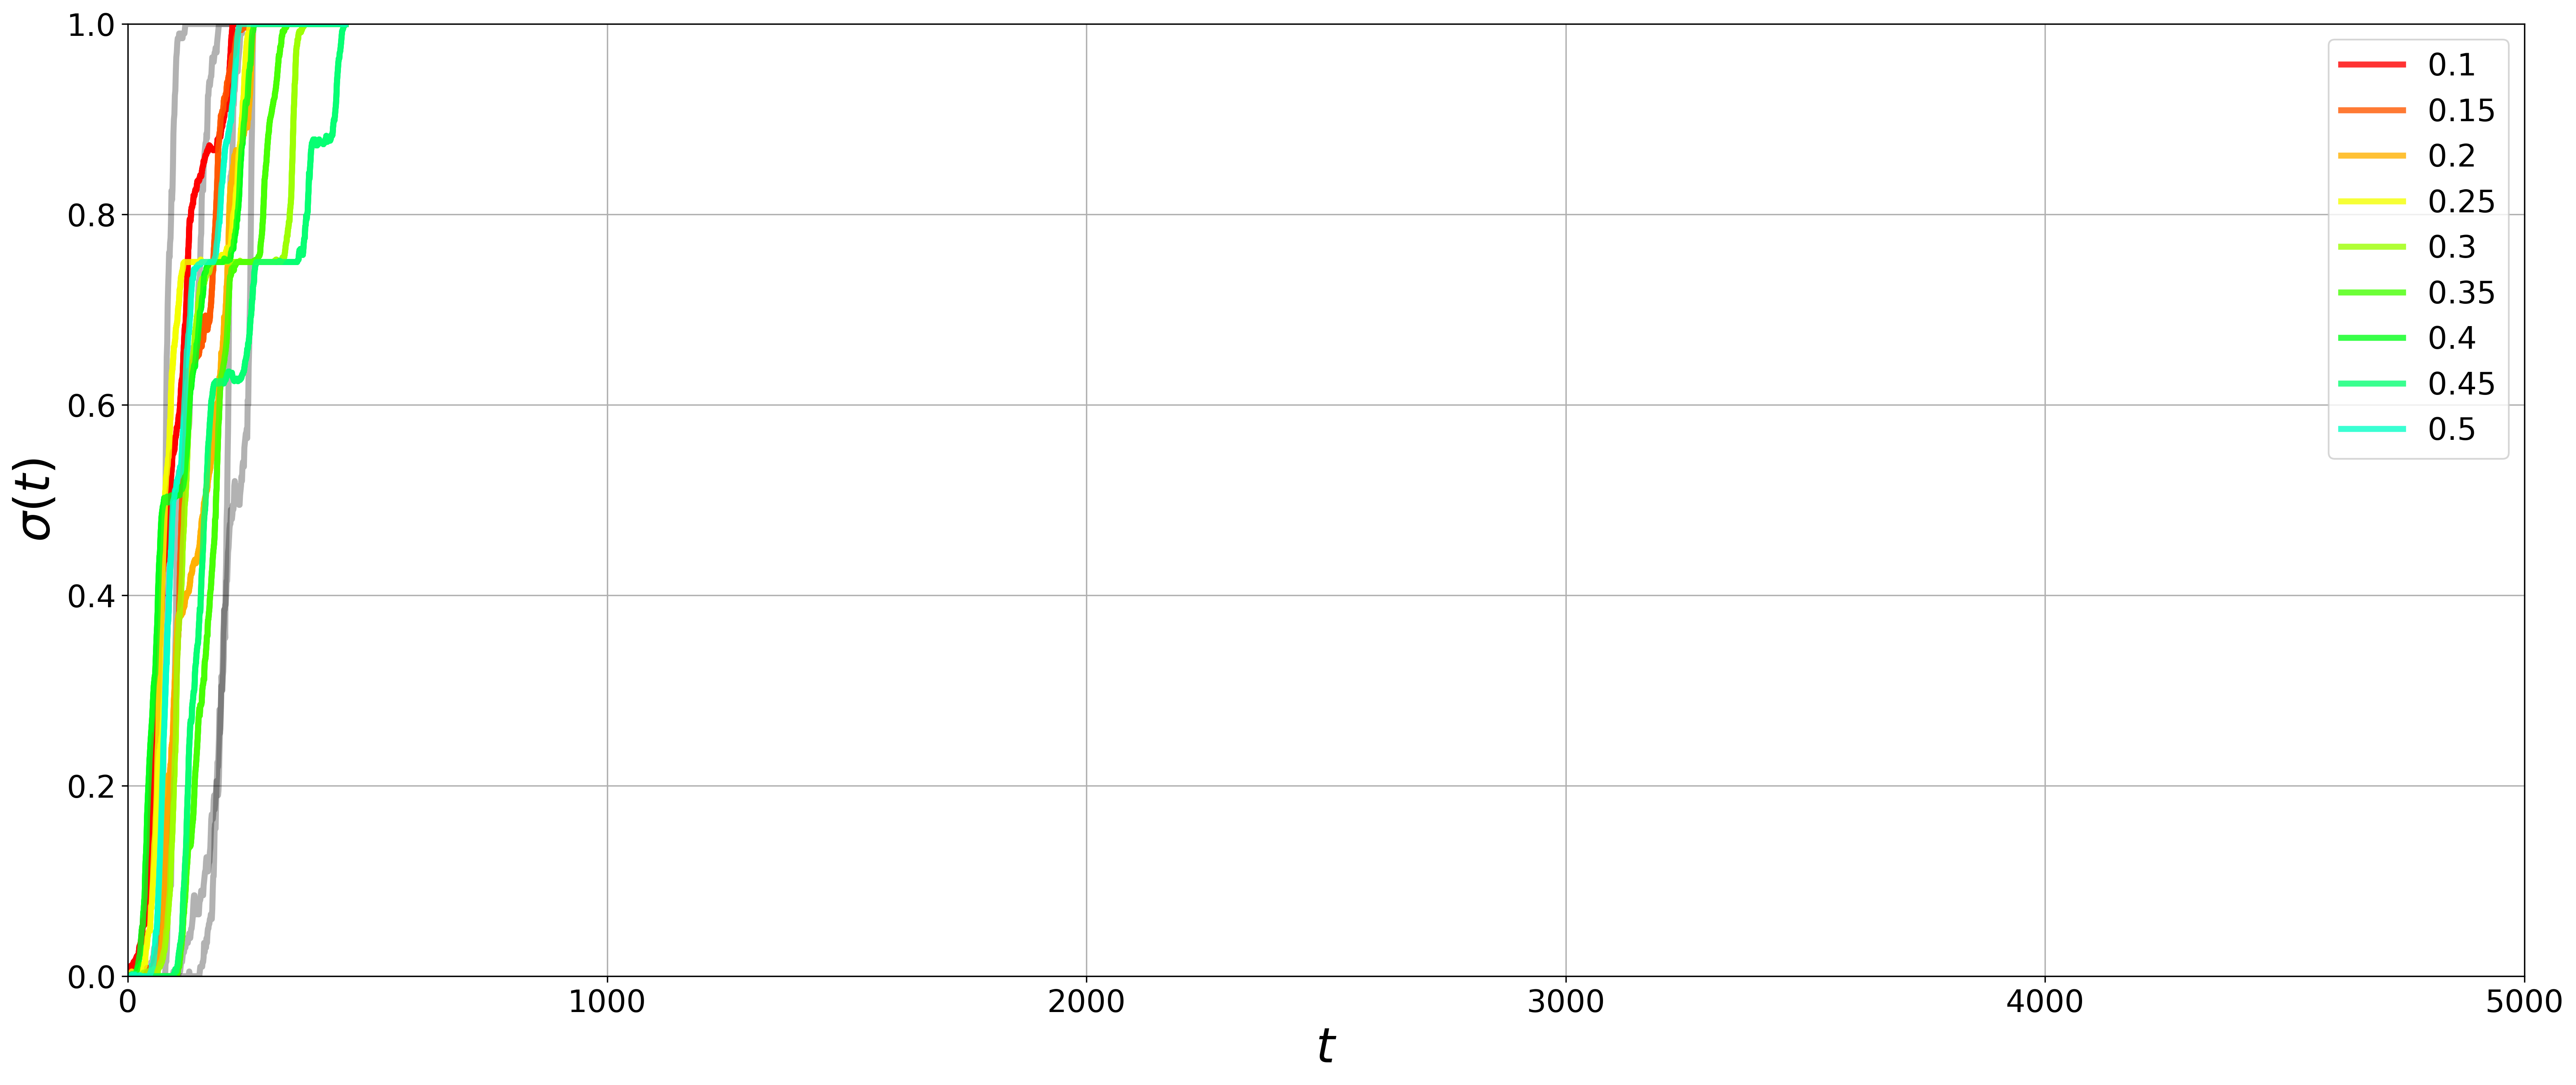

In [47]:
simulation_id = f'exp0\\e300'
borders = [500, 1000, 2000, 5000]

show_exact_simulation = True
exact_simulations = {
	GraphType.ring_subgraph: 2,
	GraphType.two_city: 8
}

# --- --- --- 


sdb = SimulationDatabase(path=f'output\\merged\\merge\\{simulation_id}\\')
type_legend = True
for graph_type in graph_types:
	sdirs = [
		sdir
		for sdir in sdb.sdirs
		if (sdir.sim.func_type == func_type) and
		(sdir.sim.graph.graph_type == graph_type) 
	]
	num_sims = len(fractions) if graph_type == GraphType.ring_subgraph else len([f for f in fractions if f <= 0.5])
	if len(sdirs) != num_sims:
		raise RuntimeError(f"Expected {num_sims} SimulationDirectories after filter, got {len(sdirs)}.")


	sim = sdirs[0].sim
	
	splot = SigmaPlot(linewidth=3.5, alpha=.8, ax_tick_size=18, ax_label_size=28, figsize=(25, 10), display_legend=True)
	
	for sdir in sdirs:
		print(f'caching {sdir}...')
		sdir.cache()
	print()
	x_max = max([sdir.t_max for sdir in sdirs])


	# Отображение единичных симуляций 
	if show_exact_simulation:
		sdir = None
		if (graph_type == GraphType.two_city):
			sdir = sdirs[2]	
		elif (graph_type == GraphType.ring_subgraph):
			sdir = sdirs[8]
		else: 
			raise("This can work only with ring_subgraph or two_city")
		sdir.cache()
		for state in sdir.state_histories[:]:
			sigma_avg = sigma_mean([state], pad_to=x_max)
			
			splot.ax.plot(
				range(len(sigma_avg)),
				sigma_avg,
				color='#000000', 
				alpha=0.3,
				linewidth=splot.linewidth,
				ls=splot.linestyle,
			)


	
	for _x_right in borders:
		for i, sdir in enumerate(sdirs):
			if (type_legend):
				splot.plot(sdir, color=color[sdir.sim.graph.graph_type][i], x_max=x_max, label=str(fractions[i]) )
			else:
				splot.plot(sdir, color=color[sdir.sim.graph.graph_type][i], x_max=x_max)
		type_legend = False
		
		xright = _x_right
		splot.update_axlims(x_right=xright)
		fname = f"{sim.graph.graph_type}_{sim.func_type}_{simulation_id.split("\\")[-1]}_t={xright}" + ".png"

		# save
		splot.fig.savefig(
			os.path.join('plots', fname),
			bbox_inches='tight',
			pad_inches=0
		)
	type_legend = True
	gc.collect()




## Анимация

Здесь указывается полный путь до определенной симуляции. 
Используются две переменные:
- sdir - указывает путь до нужной папки с симуляциями
- pickle_num - называние файла симуляции, которую хочется посмотреть

Состав sdir:
- папка (`output`)
- номер генерации (`run0_____e5b4ae68-8649-4ba9-9f94-64d46a8a140a`)
- номер эксперимента (`exp0`)
- количество ребер (`e300`)
- тип графа (`ring_subgraph`)
- папка с симуляциями (`2024.06.20_13.36.34_longstep_ring_subgraph(n=200,g=100,p=0.1,pos=random)`)

В итоге путь должен выглядеть следующим образом:

```python
sdir = "output\\run0_____e5b4ae68-8649-4ba9-9f94-64d46a8a140a\\exp0\\e300\\ring_subgraph\\2024.06.20_13.36.34_longstep_ring_subgraph(n=200,g=100,p=0.1,pos=random)""
```

`pickle_num` принимает название файла с расширением `.pickle`. Это может быть значение 5, 04, 005,079 - все зависит от количества симуляций в папке. Примеры такого файла: `05.pickle`, `3.pickle` и т.п.



In [48]:
sdir = SimulationDirectory(f"output\\run0_____1db09418-c08d-4d3c-858c-24ca12c851e7\\exp0\\e300\\ring_subgraph\\2024.07.04_00.15.32_longstep_ring_subgraph(n=200,g=100,p=0.1,pos=random)")
pickle_num = '0'

# --- --- ---

sr = read_pickled(pickle_num, path=sdir.path)
animate(
    sdir.sim,
    sr,
    filename=f'test_pickle{pickle_num}',
    path=sdir.path,
    t_start=0, 
    t_end= 1000, 
    overwrite=True
)

Converting fig2img: 100%|██████████| 145/145 [00:01<00:00, 83.29it/s]


## Animate